In [303]:
#pip install openpyxl

In [304]:
import openpyxl

In [305]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import chardet
from shapely.ops import unary_union

In [306]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium 
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap

In [307]:
# Gettting the character format (encoding type)

base = open(r'../../_data/data_dengue_peru.csv', 'rb').read()
det = chardet.detect(base)
charenc = det['encoding']
charenc

'UTF-8-SIG'

### Casos de dengue

In [308]:
cv_data = pd.read_csv( r'../../_data/data_dengue_peru.csv', encoding = charenc)
cv_data.head()

C:\Users\Karla\AppData\Local\Temp\ipykernel_7012\1024288576.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  cv_data = pd.read_csv( r'../../_data/data_dengue_peru.csv', encoding = charenc)


,Año,Semana,Eventos o daños,Departamento,Distrito,Provincia,Ubigeo,Casos
0,2020,43,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,2.0
1,2021,41,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN
2,2021,42,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN
3,2020,1,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,0.0
4,2020,53,Dengue,CUSCO,MEGANTONI,LA CONVENCION,80914,2.0


In [309]:
# Limpiar los valores eliminando los separadores de miles
cv_data['Casos'] = cv_data['Casos'].astype(str).str.replace(',', '', regex=False)

# Convertir la columna a valores numéricos, manteniendo NA
cv_data['Casos'] = pd.to_numeric(cv_data['Casos'], errors='coerce')

In [310]:
# cv_data['Casos'].isna().sum()

In [311]:
# cv_data['Ubigeo'].dtype

In [312]:
# Función para convertir a str y agregar un 0 si la longitud es 5
def format_ubigeo(ubigeo):
    if pd.isna(ubigeo):
        return ubigeo  # Mantener NaN como está
    ubigeo_str = str(ubigeo)
    if len(ubigeo_str) == 5:
        return '0' + ubigeo_str
    return ubigeo_str

# Aplicar la función a la columna 'Ubigeo'
cv_data['Ubigeo'] = cv_data['Ubigeo'].apply(format_ubigeo)

cv_data['ubigeo_dep'] = cv_data['Ubigeo'].str[:2]
cv_data['ubigeo_prov'] = cv_data['Ubigeo'].str[:4]

cv_data = cv_data.rename({'Ubigeo':'ubigeo'}, axis =1 )
cv_data #así queda el df de casos de dengue


,Año,Semana,Eventos o daños,Departamento,Distrito,Provincia,ubigeo,Casos,ubigeo_dep,ubigeo_prov
0,2020,43,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,2.0,08,0809
1,2021,41,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN,18,1801
2,2021,42,Dengue,MOQUEGUA,MOQUEGUA,MARISCAL NIETO,180101,NaN,18,1801
3,2020,1,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,0.0,08,0809
4,2020,53,Dengue,CUSCO,MEGANTONI,LA CONVENCION,080914,2.0,08,0809
...,...,...,...,...,...,...,...,...,...,...
172139,2021,49,Dengue,MADRE DE DIOS,MADRE DE DIOS,MANU,170203,NaN,17,1702
172140,2021,49,Dengue,MADRE DE DIOS,TAHUAMANU,TAHUAMANU,170303,NaN,17,1703
172141,2021,50,Dengue,MADRE DE DIOS,MADRE DE DIOS,MANU,170203,NaN,17,1702
172142,2021,50,Dengue,MADRE DE DIOS,TAHUAMANU,TAHUAMANU,170303,NaN,17,1703


### Shapefile

In [313]:
# Upload shape file at district level
maps = gpd.read_file(r'../../_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp')

In [314]:
maps = maps.rename({'UBIGEO':'ubigeo'}, axis =1 )

maps['ubigeo_dep'] = maps['ubigeo'].str[:2]
maps['ubigeo_prov'] = maps['ubigeo'].str[:4]
maps = maps[['ubigeo','ubigeo_dep','ubigeo_prov','geometry']]
print(maps.crs)

EPSG:4326


In [315]:
# Agrupar por provincia
gdf_prov = maps.groupby('ubigeo_prov').agg({
    'geometry': lambda x: unary_union(x) 
}).reset_index()

# Convertir a GeoDataFrame
gdf_prov = gpd.GeoDataFrame(gdf_prov, geometry='geometry')

# Asegurarse de que el CRS está definido
gdf_prov.set_crs(maps.crs, inplace=True)

# Verificar el GeoDataFrame resultante
print(gdf_prov.crs)

# Shapefile de provincia: gdf_prov

EPSG:4326


In [316]:
# Agrupar por departamento
gdf_dep = maps.groupby('ubigeo_dep').agg({
    'geometry': lambda x: unary_union(x) 
}).reset_index()

# Convertir a GeoDataFrame
gdf_dep = gpd.GeoDataFrame(gdf_dep, geometry='geometry')

# Asegurarse de que el CRS está definido
gdf_dep.set_crs(maps.crs, inplace=True)

# Verificar el GeoDataFrame resultante
print(gdf_dep.crs)

# Shapefile de provincia: gdf_dep

EPSG:4326


In [317]:
gdf_dist=maps[['ubigeo','geometry']]
print(gdf_dist.crs)

# Shapefile de distrito: gdf_dist

EPSG:4326


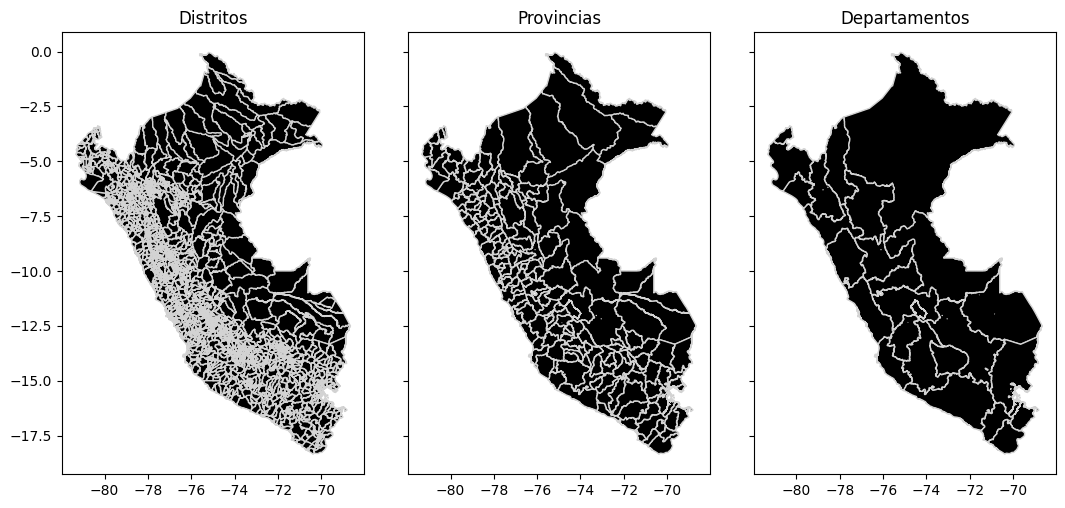

In [330]:
# Gráficos de mapas
fig, axs = plt.subplots(1, 3, figsize=(11, 5), sharex=True, sharey=True)

# Graficar el GeoDataFrame de distritos
gdf_dist.plot(ax=axs[0], edgecolor='lightgrey', color='black')
axs[2].set_title('Departamentos')

# Graficar el GeoDataFrame de provincias
gdf_prov.plot(ax=axs[1], edgecolor='lightgrey', color='black')
axs[1].set_title('Provincias')

# Graficar el GeoDataFrame de departamentos
gdf_dep.plot(ax=axs[2], edgecolor='lightgrey', color='black')
axs[0].set_title('Distritos')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar la figura
plt.show()

### Año 2021 - distrito

In [319]:
grouped1 = cv_data.groupby(['ubigeo', 'Año']).agg({
    'Casos': 'sum', # Sumar los casos
    'Distrito': 'first'
}).reset_index()

df1 = grouped1[grouped1['Año'] == 2021]
df1 = df1.reset_index(drop=True)


In [320]:
df_dist = pd.merge(gdf_dist, df1, how="outer", on=["ubigeo"])

df_dist = gpd.GeoDataFrame(df_dist, geometry='geometry')
df_dist.set_crs(epsg=4326, inplace=True)
print(df_dist.crs)

EPSG:4326


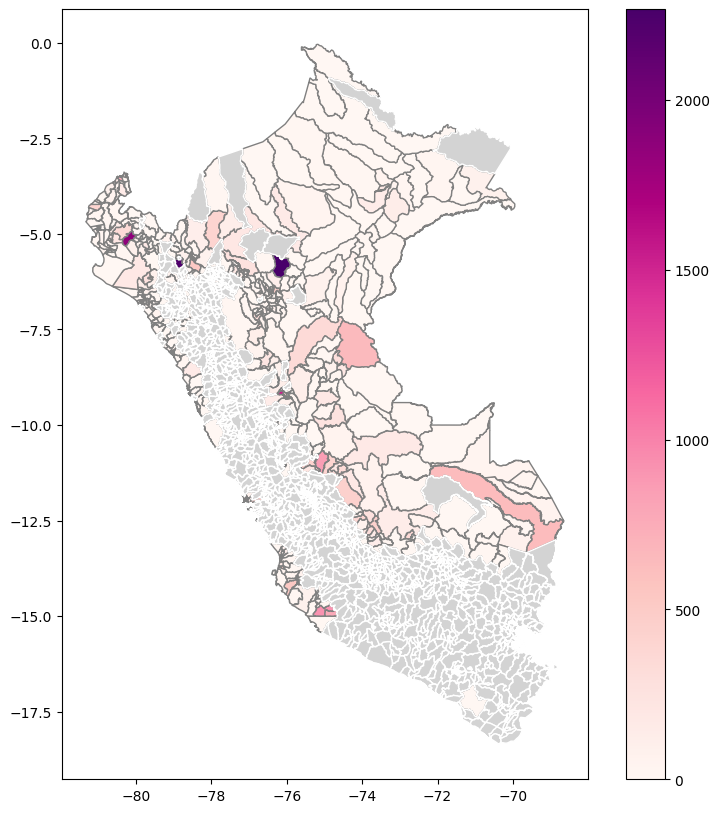

In [332]:
# Mask for missing values
mask_na = df_dist['Casos'].isna()

fig, ax = plt.subplots(figsize=(10,10))
df_dist[~mask_na].plot(column='Casos', cmap='RdPu', edgecolor='gray', ax=ax, legend=True, linestyle='-')
df_dist[mask_na].plot(edgecolor='white', ax=ax, color='lightgray', linestyle='-')

plt.show()

### Año 2021 - provincia

In [322]:
grouped2 = cv_data.groupby(['ubigeo_prov', 'Año']).agg({
    'Casos': 'sum', # Sumar los casos
    'Provincia': 'first'
}).reset_index()

df2 = grouped2[grouped2['Año'] == 2021]
df2 = df2.reset_index(drop=True)

In [323]:
df_prov = pd.merge(gdf_prov, df2, how="outer", on=["ubigeo_prov"])

df_prov = gpd.GeoDataFrame(df_prov, geometry='geometry')
df_prov.set_crs(epsg=4326, inplace=True)
print(df_prov.crs)

EPSG:4326


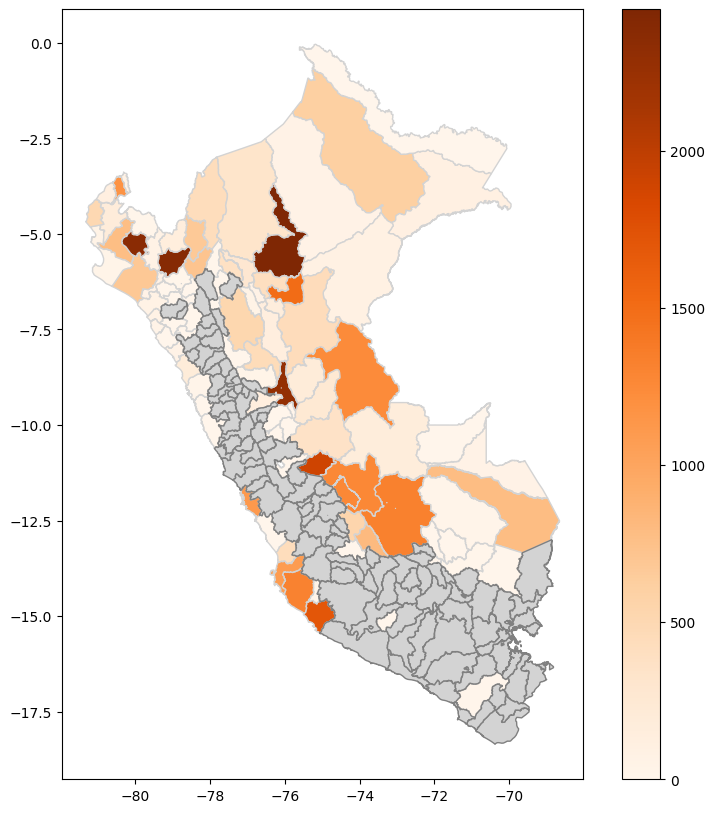

In [334]:
# Mask for missing values
mask_na = df_prov['Casos'].isna()

fig, ax = plt.subplots(figsize=(10,10))
df_prov[~mask_na].plot(column='Casos', cmap='Oranges', edgecolor='lightgray', ax=ax, legend=True, linestyle='-')
df_prov[mask_na].plot(edgecolor='gray', ax=ax, color='lightgray', linestyle='-')

plt.show()

### Años - Departamento

In [325]:
grouped3 = cv_data.groupby(['ubigeo_dep', 'Año']).agg({
    'Casos': 'sum', # Sumar los casos
    'Departamento': 'first'
}).reset_index()

In [326]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]

# Crear un diccionario para almacenar los GeoDataFrames por año
geo_dataframes = {}

for year in years:
    # Filtrar los datos para el año actual
    df3_year = grouped3[grouped3['Año'] == year].reset_index(drop=True)
    
    # Realizar el merge con el GeoDataFrame de departamentos
    df_dep_year = pd.merge(gdf_dep, df3_year, how="outer", on=["ubigeo_dep"])
    
    # Convertir a GeoDataFrame
    df_dep_year = gpd.GeoDataFrame(df_dep_year, geometry='geometry')
    df_dep_year.set_crs(epsg=4326, inplace=True)
    
    # Almacenar en el diccionario con el año como clave
    geo_dataframes[year] = df_dep_year

# Imprimir CRS para verificar
for year, gdf in geo_dataframes.items():
    print(f"CRS para el año {year}: {gdf.crs}")

CRS para el año 2015: EPSG:4326
CRS para el año 2016: EPSG:4326
CRS para el año 2017: EPSG:4326
CRS para el año 2018: EPSG:4326
CRS para el año 2019: EPSG:4326
CRS para el año 2020: EPSG:4326
CRS para el año 2021: EPSG:4326


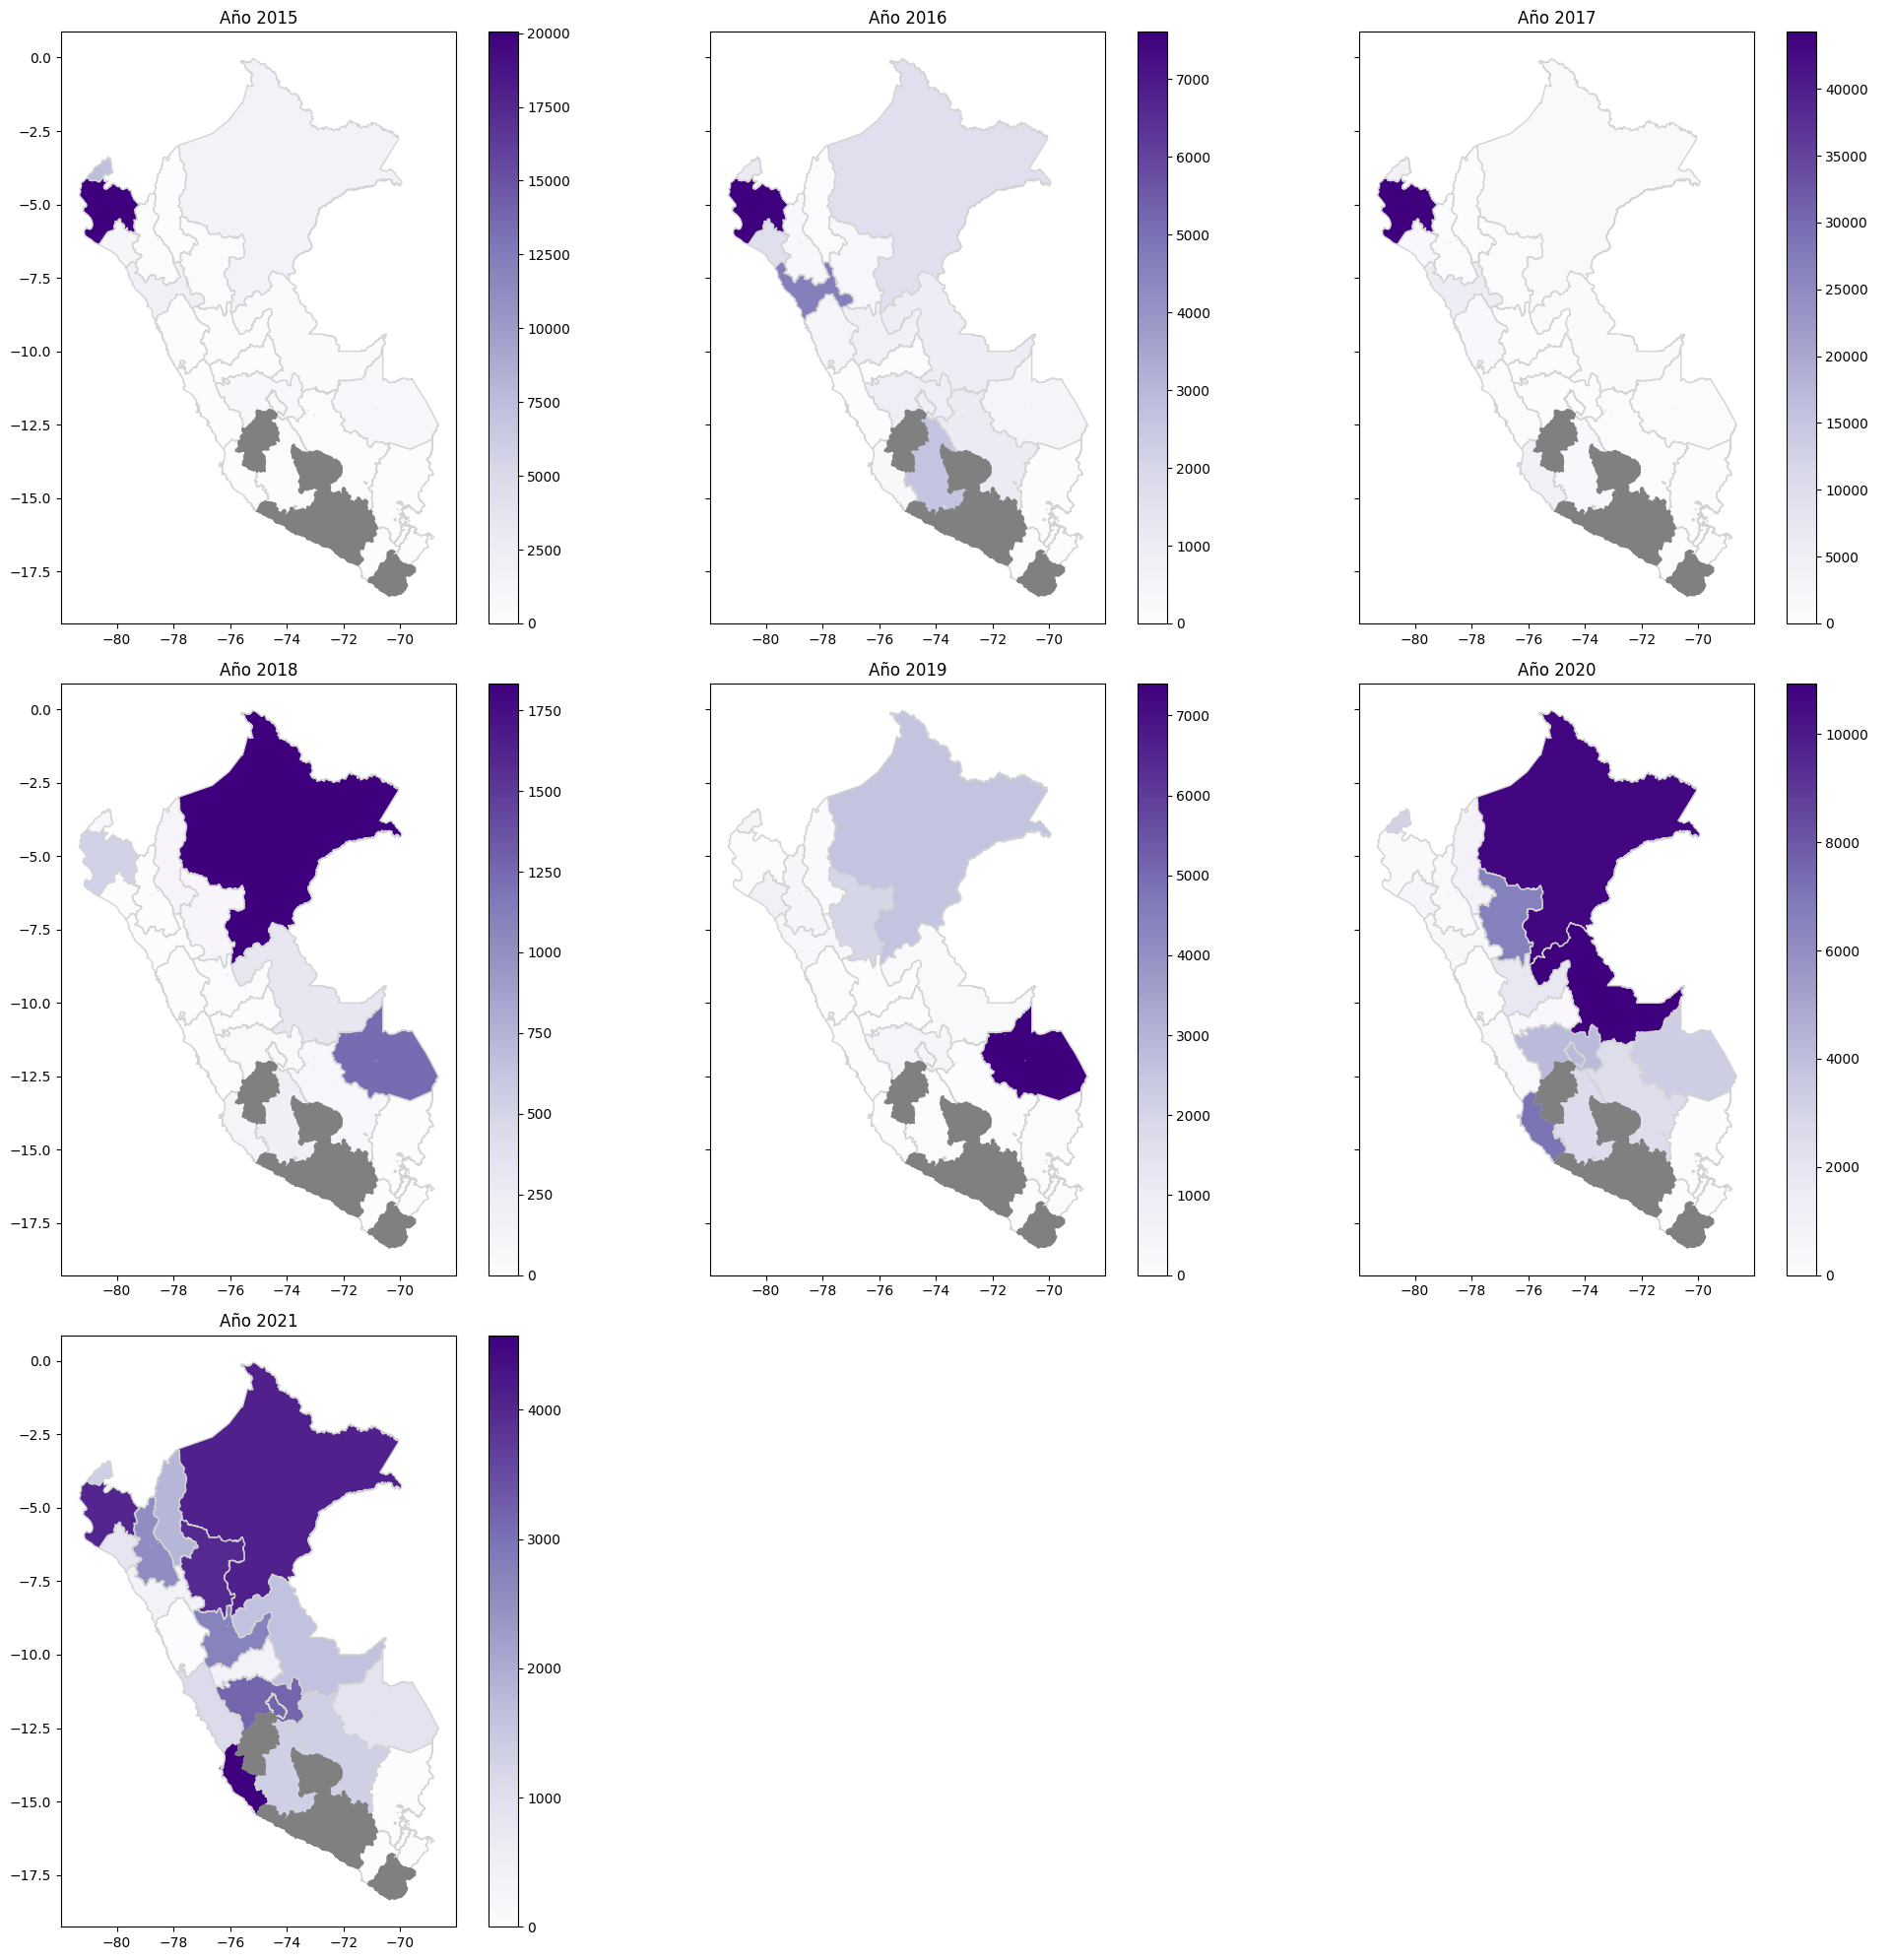

In [327]:
# Obtener los años y número de GeoDataFrames
years = list(geo_dataframes.keys())
num_years = len(years)

# Crear la figura y los ejes para los subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=False, sharey=True)

# Aplanar el array de ejes para facilitar el acceso
axs = axs.flatten()

# Graficar cada GeoDataFrame en el subplot correspondiente
for i, (year, gdf) in enumerate(geo_dataframes.items()):
    ax = axs[i]
    
    # Crear la máscara para los valores NaN en la columna 'Casos'
    if 'Casos' in gdf.columns:
        mask_na = gdf['Casos'].isna()
        
        # Graficar los valores no nulos
        gdf[~mask_na].plot(column='Casos', ax=ax, edgecolor='lightgray', cmap='Purples', legend = True)
        
        # Graficar los valores NaN en color diferente
        gdf[mask_na].plot(ax=ax, edgecolor='gray', color='gray')
        
        # Establecer el título para el subplot
        ax.set_title(f'Año {year}')
    else:
        ax.text(0.5, 0.5, f'No datos para el año {year}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        ax.set_title(f'Sin información')

# Ocultar los subplots no utilizados
for j in range(num_years, len(axs)):
    axs[j].axis('off')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar la figura
plt.show()


### Trimestres

In [328]:
# Lista de trimestres
trimesters = ['1', '2', '3', '4']

# Crear un diccionario para almacenar los GeoDataFrames por trimestre
geo_df4 = {}

# Definir los rangos de semanas para cada trimestre
trimestre_ranges = {
    '1': (1, 13),
    '2': (14, 26),
    '3': (27, 40),
    '4': (41, 53)
}

for trimester in trimesters:
    # Obtener el rango de semanas para el trimestre actual
    start_week, end_week = trimestre_ranges[trimester]
    
    # Filtrar los datos para el trimestre actual
    df4_trimester = cv_data[(cv_data['Semana'] >= start_week) & (cv_data['Semana'] <= end_week)]
    
    # Agrupar los datos por 'ubigeo_dep' y sumar los casos
    grouped_trimester = df4_trimester.groupby(['ubigeo_dep']).agg({
        'Casos': 'sum', # Sumar los casos
        'Departamento': 'first'
    }).reset_index()
    
    # Realizar el merge con el GeoDataFrame de departamentos
    df4_dep_trimester = pd.merge(gdf_dep, grouped_trimester, how="outer", on=["ubigeo_dep"])
    
    # Convertir a GeoDataFrame
    df4_dep_trimester = gpd.GeoDataFrame(df4_dep_trimester, geometry='geometry')
    df4_dep_trimester.set_crs(epsg=4326, inplace=True)
    
    # Almacenar en el diccionario con el trimestre como clave
    geo_df4[trimester] = df4_dep_trimester

# Imprimir CRS para verificar
for trimester, gdf in geo_df4.items():
    print(f"CRS para el trimestre {trimester}: {gdf.crs}")


CRS para el trimestre 1: EPSG:4326
CRS para el trimestre 2: EPSG:4326
CRS para el trimestre 3: EPSG:4326
CRS para el trimestre 4: EPSG:4326


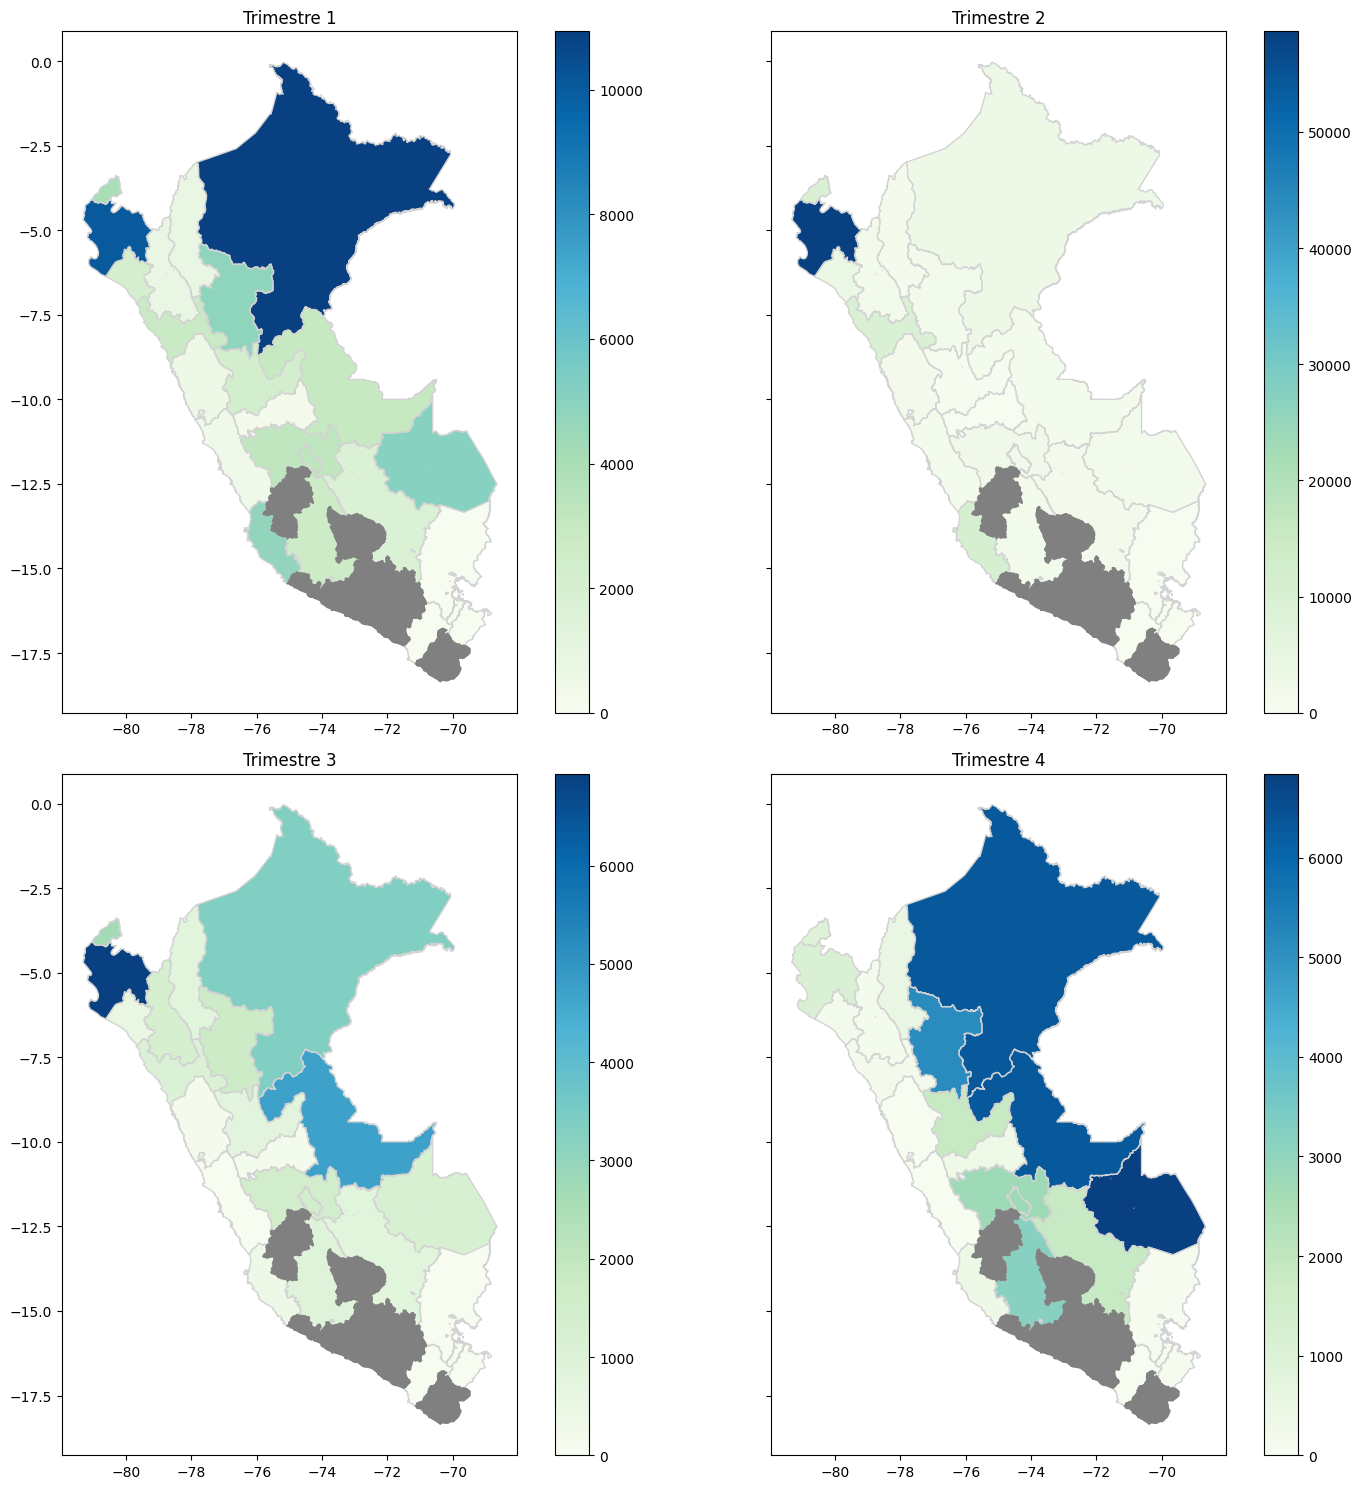

In [329]:
# Obtener los años y número de GeoDataFrames
trim = list(geo_df4.keys())
num_trim = len(trim)

# Crear la figura y los ejes para los subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=False, sharey=True)

# Aplanar el array de ejes para facilitar el acceso
axs = axs.flatten()

# Graficar cada GeoDataFrame en el subplot correspondiente
for i, (trimestre, gdf) in enumerate(geo_df4.items()):
    ax = axs[i]
    
    # Crear la máscara para los valores NaN en la columna 'Casos'
    if 'Casos' in gdf.columns:
        mask_na = gdf['Casos'].isna()
        
        # Graficar los valores no nulos
        gdf[~mask_na].plot(column='Casos', ax=ax, edgecolor='lightgray', cmap='GnBu', legend = True)
        
        # Graficar los valores NaN en color diferente
        gdf[mask_na].plot(ax=ax, edgecolor='gray', color='gray')
        
        # Establecer el título para el subplot
        ax.set_title(f'Trimestre {trimestre}')
    else:
        ax.text(0.5, 0.5, f'No datos para el trimestre {trimestre}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        ax.set_title(f'Sin información')

# Ocultar los subplots no utilizados
for j in range(num_trim, len(axs)):
    axs[j].axis('off')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()

# Mostrar la figura
plt.show()